<a href="https://colab.research.google.com/github/JCaesarLG/ML-Projects/blob/main/Food_Delivery_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

DATA EXTRACTION

---

In [51]:
delivery = pd.read_csv(f"/content/drive/MyDrive/Raw_Data/Food_Delivery_Times.csv")
delivery.head(2), delivery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


(   Order_ID  Distance_km Weather Traffic_Level Time_of_Day Vehicle_Type  \
 0       522         7.93   Windy           Low   Afternoon      Scooter   
 1       738        16.42   Clear        Medium     Evening         Bike   
 
    Preparation_Time_min  Courier_Experience_yrs  Delivery_Time_min  
 0                    12                     1.0                 43  
 1                    20                     2.0                 84  ,
 None)

DATA PREPROCESSING

---

In [52]:
modes = {
    'Weather': lambda x: x.mode()[0],
    'Traffic_Level': lambda x: x.mode()[0],
    'Time_of_Day': lambda x: x.mode()[0],
    'Courier_Experience_yrs': lambda x: x.mean().round()
}

for col, func in modes.items():
  mode_maps = delivery.groupby('Vehicle_Type')[col].agg(func)
  delivery[col] = delivery[col].fillna(delivery['Vehicle_Type'].map(mode_maps))

delivery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 1000 non-null   object 
 3   Traffic_Level           1000 non-null   object 
 4   Time_of_Day             1000 non-null   object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  1000 non-null   float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


In [53]:
deliver = delivery.copy()

In [54]:
enc = LabelEncoder()
obj = deliver.select_dtypes(include='object').columns
for i in obj:
  deliver[i] = enc.fit_transform(deliver[i])

deliver.head(2)

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,4,1,0,2,12,1.0,43
1,738,16.42,0,2,1,0,20,2.0,84


DATA ANALYSIS

---

In [55]:
sns.set()

In [56]:
def plot_style(data, column1, column2=None, plot_type='hist', style='darkgrid', **kwargs):
  sns.set_style(style)
  plt.figure(figsize=(15,5))
  if plot_type == 'hist':
    sns.histplot(data=data, x=column1, kde=True, kde_kws=dict(cut=3), **kwargs)
  elif plot_type == 'box':
    sns.boxplot(data=data, x=column1, y=column2, **kwargs)
  elif plot_type == 'line':
    sns.lineplot(data=data, x=column1, y=column2, **kwargs)
  else:
    raise ValueError (f"Unsupported Plot Type {plot_type}")

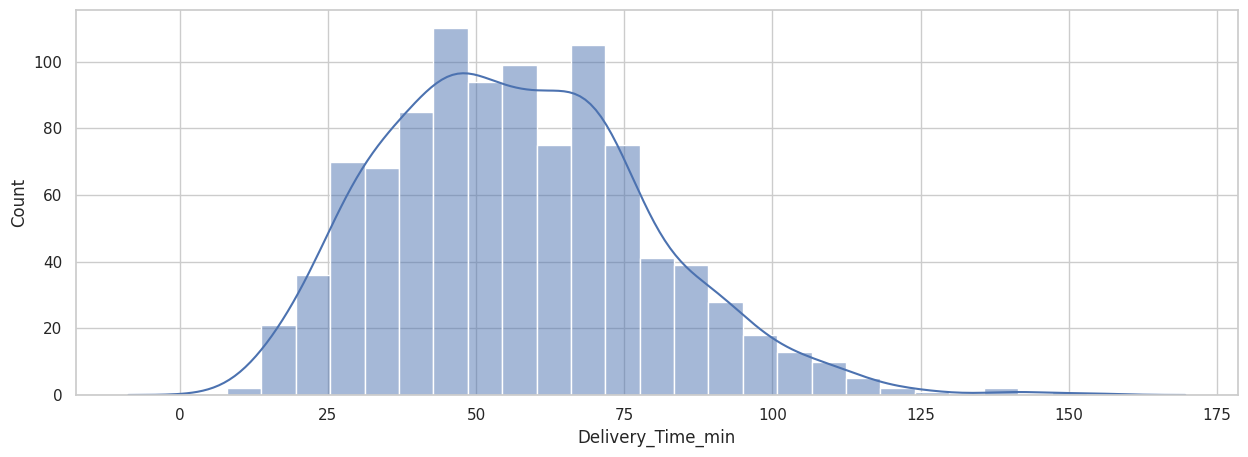

In [57]:
plot_style(delivery, column1='Delivery_Time_min', plot_type='hist', style='whitegrid')

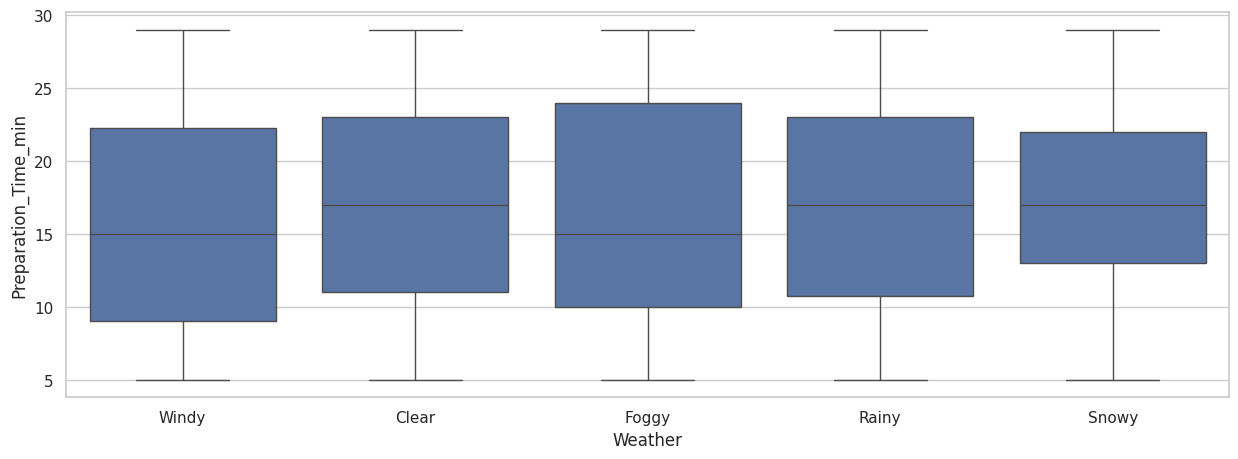

In [58]:
plot_style(delivery, column1='Weather', column2='Preparation_Time_min', plot_type='box', style='whitegrid')

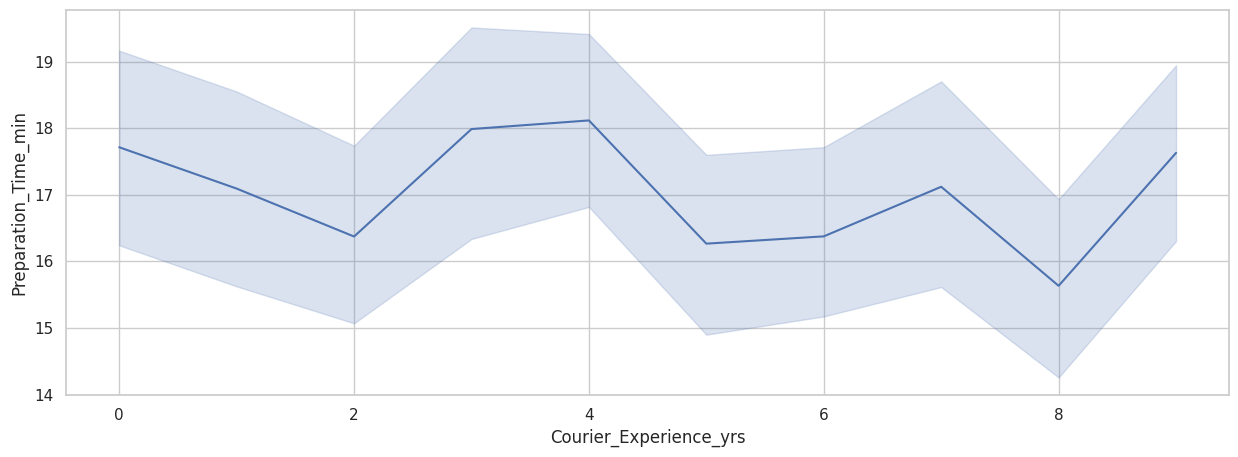

In [63]:
plot_style(delivery, column1='Courier_Experience_yrs', column2='Preparation_Time_min', plot_type='line', style='whitegrid')

In [60]:
corr = deliver.corr()
print(corr['Delivery_Time_min'].sort_values(ascending=False).round(3)*100)

Delivery_Time_min         100.0
Distance_km                78.1
Preparation_Time_min       30.7
Weather                    13.3
Time_of_Day                -0.3
Vehicle_Type               -0.7
Order_ID                   -3.7
Courier_Experience_yrs     -8.9
Traffic_Level             -10.5
Name: Delivery_Time_min, dtype: float64


MACHINE LEARNING MODEL BUILDING

---

In [61]:
X = deliver.iloc[:,:-1]
y = deliver.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sc = StandardScaler()
sc.fit(X_train)
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

rg = RandomForestRegressor(n_estimators=100, random_state=42)
rg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [62]:
test_pred = rg.predict(X_test)
r2_scr = r2_score(y_test, test_pred)
print(f"r2 score for test is {r2_scr}")

importance = rg.feature_importances_.round(3)*100
columns = X.columns
feature_importance = pd.DataFrame({'Feature': columns,
                                   'Importance':importance}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance")
print(feature_importance)

r2 score for test is 0.7413603030027365

Feature Importance
                  Feature  Importance
1             Distance_km        68.2
6    Preparation_Time_min        14.7
0                Order_ID         6.5
7  Courier_Experience_yrs         3.6
2                 Weather         2.4
3           Traffic_Level         2.1
4             Time_of_Day         1.3
5            Vehicle_Type         1.1
